----
# <b> Mini Project ML for Time Series
# Matteo Marengo | matteo.marengo@ens-paris-saclay.fr
# Hugo Robert | hugo.robert@ens-paris-saclay.fr
----

# <b> 1 : Installation and Libraries </b>

In [1]:
!pip install tsfel
!pip install cesium
!pip install tsfresh

In [2]:
# Import useful libraries
import numpy as np
import tsfel
import json
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import argrelmin
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----
----
#<b> 2 : Dataset</b>

Ce datasset est composé de signaux radars. Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient:

- la date de début de détection de l'impulsion (en ms)

- la largeur ou durée de l'impulsion (en ms)

- la puissance de l'impulsion (en dB / référence)

- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)

- la fréquence de l'impulsion (en Ghz)

In [4]:
def naive_pred(i):
    """for a sample i, return 1 if the model predicts menace, 0 otherwise

    Args:
        i (int): _description_

    Returns:
        _type_: _description_
    """
    # pdws = np.load('./radars_data/test/pdw-'+str(i)+'.npz')
    pdws = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    if np.std(frequences)>0.025:
        return 1
    else:
        if np.mean(frequences)<2:
            return 1
    return 0

accuracy: 0.73875
precision: 0.6746031746031746
recall: 0.8831168831168831
f1-score: 0.7649043869516311


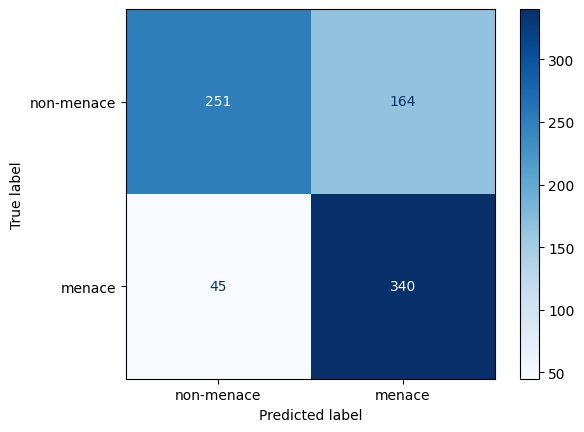

In [5]:
with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test_labels.json') as f:
    test_labels = json.load(f)
    test_labels = [test_labels[f'pdw-{i}']=='menace' for i in range(len(test_labels))]


total = len(test_labels)
score=0
preds=[]
for i in range(total):
    preds.append(naive_pred(i))
# plot results
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, preds), display_labels=['non-menace', 'menace'])
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"precision: {precision_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"f1-score: {f1_score(test_labels, preds)}")


<class 'numpy.ndarray'>
(672,)
()


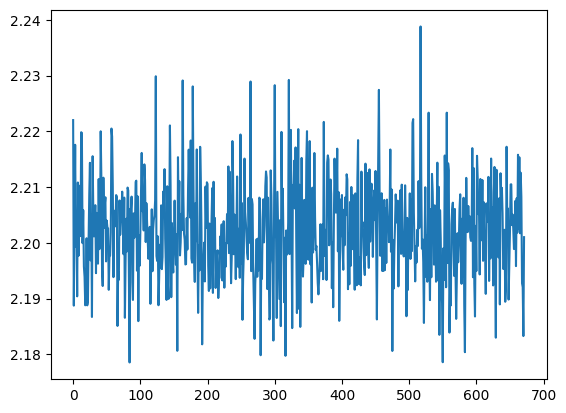

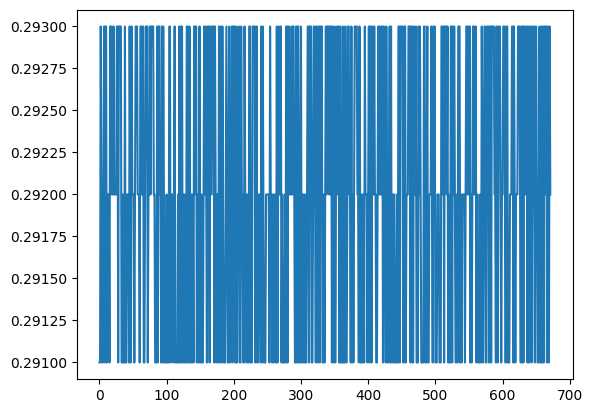

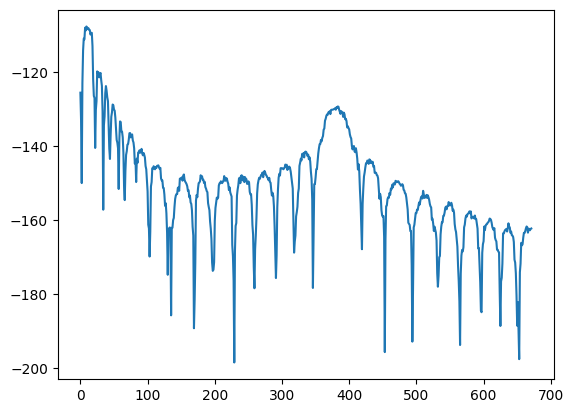

In [6]:
pdws = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train/pdw-'+str(0)+'.npz')
frequences=pdws['frequence']
largeurs = pdws['largeur']
puissances = pdws['puissance']
print(type(frequences))
print(frequences.shape)
print(frequences[0].shape)
plt.plot(frequences)
plt.show()
plt.plot(largeurs)
plt.show()
plt.plot(puissances)
plt.show()

----
----
# <b> 3 : Modèle avec features personnalisés</b>

## <b> 3.1 : Définition des Features spécialisées </b>

In [7]:
def compute_T(time):
    """_summary_

    Args:
        time (_type_): _description_

    Returns:
        _type_: _description_
    """
    delta_t = np.diff(time)
    # afin d'obtenir d'estimer une valeur de T le plus précisemment et rapidement
    # on mesure la moyenne des 20 éléments les plus petits de delta_t qui donnent chacun une estimation de T
    delta_t.sort()
    return np.mean(delta_t[:20])

def compute_large_lob(puissance):
    """compute caracteristics of puissance curve

    Args:
        puissance (Any)

    Returns:
        nb_local_minimum (int): number of local minimum in puissance
        weight_large_lob (int): weight of the largest lob
        height_large_lob (int): height of the largest lob
    """
    local_min_indexes = argrelmin(puissance, order=2)[0] #  computation of local minimum indexes
    # caracteristics of largest lob
    index_begin_large_lob = local_min_indexes[np.argmax(np.diff(local_min_indexes))]
    index_end_large_lob = local_min_indexes[1+np.argmax(np.diff(local_min_indexes))]
    height_large_lob = np.max(puissance[index_begin_large_lob:index_end_large_lob])-puissance[index_end_large_lob]
    weight_large_lob = np.max(np.diff(local_min_indexes)) * 10/len(puissance)
    return len(local_min_indexes), weight_large_lob, height_large_lob

----
## <b> 3.2 : Preparation des données </b>

In [9]:
with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train_labels.json') as f:
    dict_labels_train = json.load(f)
    print('Number of training examples: ',len(dict_labels_train)) # number of training examples

with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test_labels.json') as f:
    dict_labels_test = json.load(f)
    print('Number of training examples: ',len(dict_labels_test)) # number of testing examples

# Load the train data in a dataset to perform binary classification

X_train = np.zeros((len(dict_labels_train),16))
y_train = np.zeros((len(dict_labels_train),1))
X_test = np.zeros((len(dict_labels_test),16))
y_test = np.zeros((len(dict_labels_test),1))
print ('Création de X_train, y_train, X_test et y_test\n')
print('Format des données:')
print('\tFormat de X_train: ',X_train.shape)
print('\tFormat de y_train: ',y_train.shape)
print('\tFormat de X_test: ',X_test.shape)
print('\tFormat de y_test: ',y_test.shape)

for i in range(len(dict_labels_train)):
    pdws = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    largeurs = pdws['largeur']
    puissances = pdws['puissance']
    fft_puissance = abs(np.fft.fft(puissances))
    fft_frequence = abs(np.fft.fft(frequences))
    phi = pdws['phi']
    theta = pdws['theta']

    if dict_labels_train[f'pdw-{i}'] == 'menace':
        y_train[i] = 1
    else:
        y_train[i] = 0
    X_train[i,0]=np.std(frequences)
    X_train[i,1]=np.mean(frequences)
    X_train[i,2]=np.mean(largeurs)
    X_train[i,3]=np.mean(puissances)
    X_train[i,4]=compute_T(pdws['date'])
    X_train[i,5]=np.max(fft_puissance)
    X_train[i,6]=np.min(fft_puissance)
    X_train[i,7]=np.mean(fft_puissance)
    X_train[i,8]=np.std(fft_puissance)
    X_train[i,9], X_train[i,10], X_train[i,11] = compute_large_lob(puissances)
    X_train[i,12]=np.max(fft_frequence)
    X_train[i,13]=np.min(fft_frequence)
    X_train[i,14]=np.mean(fft_frequence)
    X_train[i,15]=np.std(fft_frequence)

for i in range(len(dict_labels_test)):
    pdws = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    largeurs = pdws['largeur']
    puissances = pdws['puissance']
    fft_puissance = abs(np.fft.fft(puissances))
    fft_frequence = abs(np.fft.fft(frequences))
    phi = pdws['phi']
    theta = pdws['theta']

    if dict_labels_test[f'pdw-{i}'] == 'menace':
        y_test[i] = 1
    else:
        y_test[i] = 0
    X_test[i,0]=np.std(frequences)
    X_test[i,1]=np.mean(frequences)
    X_test[i,2]=np.mean(largeurs)
    X_test[i,3]=np.mean(puissances)
    X_test[i,4]=compute_T(pdws['date'])
    X_test[i,5]=np.max(fft_puissance)
    X_test[i,6]=np.min(fft_puissance)
    X_test[i,7]=np.mean(fft_puissance)
    X_test[i,8]=np.std(fft_puissance)
    X_test[i,9], X_test[i,10], X_test[i,11] = compute_large_lob(puissances)
    X_test[i,12]=np.max(fft_frequence)
    X_test[i,13]=np.min(fft_frequence)
    X_test[i,14]=np.mean(fft_frequence)
    X_test[i,15]=np.std(fft_frequence)

y_train = y_train.ravel()
y_test = y_test.ravel()

# Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print ('Data are normalized !\n')

Number of training examples:  2000
Number of training examples:  800
Création de X_train, y_train, X_test et y_test

Format des données:
	Format de X_train:  (2000, 16)
	Format de y_train:  (2000, 1)
	Format de X_test:  (800, 16)
	Format de y_test:  (800, 1)
Data are normalized !



----
## <b> 3.3 : Entrainement du modèle </b>

In [10]:
# random forest classification
clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_perso = accuracy_score(y_test,y_pred)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_score(y_test, y_pred)) + '\033[0m')

Accuracy score with RF: 0.88375


----
----
# <b> 4 : Modèle avec features génériques TSFEL </b>

## <b> 4.1 : Préparation des données </b>

In [14]:
with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train_labels.json') as f:
    dict_labels_train = json.load(f)
    print('Number of training examples: ',len(dict_labels_train)) # number of training examples

with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test_labels.json') as f:
    dict_labels_test = json.load(f)
    print('Number of test examples: ',len(dict_labels_test)) # number of test examples


fs = 100
cfg_file = tsfel.get_features_by_domain()

y_train = np.zeros((len(dict_labels_train),1))
y_test = np.zeros((len(dict_labels_test),1))
freq_train, largeur_train, puissance_train, date_train = [], [], [], []
freq_test, largeur_test, puissance_test, date_test = [], [], [], []

for i in range(len(dict_labels_train)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train/pdw-'+str(i)+'.npz')
    freq_train.append(pdw['frequence'])
    largeur_train.append(pdw['largeur'])
    puissance_train.append(pdw['puissance'])
    date_train.append(pdw['date'])
    if dict_labels_train[f'pdw-{i}'] == 'menace':
        y_train[i] = 1
    else:
        y_train[i] = 0

for i in range(len(dict_labels_test)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test/pdw-'+str(i)+'.npz')
    freq_test.append(pdw['frequence'])
    largeur_test.append(pdw['largeur'])
    puissance_test.append(pdw['puissance'])
    date_test.append(pdw['date'])
    if dict_labels_test[f'pdw-{i}'] == 'menace':
        y_test[i] = 1
    else:
        y_test[i] = 0

y_train = y_train.ravel()
y_test = y_test.ravel()


Number of training examples:  2000
Number of test examples:  800


----
## <b> 4.2 : Extraction des Features </b>

In [15]:
# extraction de l'enssemble des features
freq_train_features = tsfel.time_series_features_extractor(cfg_file, freq_train, fs=fs).add_prefix('freq_')
freq_test_features = tsfel.time_series_features_extractor(cfg_file, freq_test, fs=fs).add_prefix('freq_')
largeur_train_features = tsfel.time_series_features_extractor(cfg_file, largeur_train, fs=fs).add_prefix('largeur_')
largeur_test_features = tsfel.time_series_features_extractor(cfg_file, largeur_test, fs=fs).add_prefix('largeur_')
puissance_train_features = tsfel.time_series_features_extractor(cfg_file, puissance_train, fs=fs).add_prefix('puissance_')
puissance_test_features = tsfel.time_series_features_extractor(cfg_file, puissance_test, fs=fs).add_prefix('puissance_')
date_train_features = tsfel.time_series_features_extractor(cfg_file, date_train, fs=fs).add_prefix('date_')
date_test_features = tsfel.time_series_features_extractor(cfg_file, date_test, fs=fs).add_prefix('date_')

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [16]:
train_dfs = [freq_train_features, largeur_train_features, puissance_train_features, date_train_features]
test_dfs = [freq_test_features, largeur_test_features, puissance_test_features, date_test_features]

test_features, train_features = pd.DataFrame(), pd.DataFrame()

for train_feature, test_feature in zip(train_dfs, test_dfs):

    corr_features = tsfel.correlated_features(train_feature)
    train_feature.drop(corr_features, axis=1, inplace=True)
    test_feature.drop(corr_features, axis=1, inplace=True)

    # Save the column names
    train_column_names, test_column_names = train_feature.columns, test_feature.columns
    selector = VarianceThreshold()
    train_feature = selector.fit_transform(train_feature)
    test_feature = selector.transform(test_feature)
    selected_indices = selector.get_support(indices=True)
    scaler = preprocessing.StandardScaler()
    train_feature = scaler.fit_transform(train_feature)
    test_feature = scaler.transform(test_feature)

    train_feature, test_feature = pd.DataFrame(train_feature, columns=[train_column_names[i] for i in selected_indices]), pd.DataFrame(test_feature, columns=[train_column_names[i] for i in selected_indices])

    test_features = pd.concat([test_features, pd.DataFrame(test_feature)], axis=1)
    train_features = pd.concat([train_features, pd.DataFrame(train_feature)], axis=1)

In [17]:
# find columns where train_features contains NaN values
nan_columns = train_features.columns[train_features.isna().any()].tolist()
train_features.drop(nan_columns, axis=1, inplace=True)
test_features.drop(nan_columns, axis=1, inplace=True)

print(f"number of features: {len(train_features.columns)}")

number of features: 1073


----
## <b> 4.3 : Résultats avec features présélectionnés </b>

In [18]:
clf = RandomForestClassifier(max_depth=20, random_state=0).fit(train_features, y_train)
y_pred = clf.predict(test_features)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_score(y_test, y_pred)) + '\033[0m')

Accuracy score with RF: 0.8875


----
## <b> 4.4 : Résultats en enlevant les features avec de la corrélation entre TS

In [19]:
# remove columns of train_features which contains 'FFT mean' in their name
train_features.drop(train_features.columns[train_features.columns.str.contains('FFT mean')], axis=1, inplace=True)
test_features.drop(test_features.columns[test_features.columns.str.contains('FFT mean')], axis=1, inplace=True)
print(f"number of features: {len(train_features.columns)}")

number of features: 159


In [20]:
corr_features = tsfel.correlated_features(train_features)
train_features.drop(corr_features, axis=1, inplace=True)
test_features.drop(corr_features, axis=1, inplace=True)
print(f"number of features: {len(train_features.columns)}")
print(f"features names: {train_features.columns}")
clf = RandomForestClassifier(max_depth=20, random_state=0).fit(train_features, y_train)


feature_importances = clf.feature_importances_

# Create a DataFrame to display feature names and their importances
importance_df = pd.DataFrame({'Feature': train_features.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)


y_pred = clf.predict(test_features)
accuracy_tsfel = accuracy_score(y_test, y_pred)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_tsfel) + '\033[0m')

number of features: 149
features names: Index(['freq_0_Absolute energy', 'freq_0_Area under the curve',
       'freq_0_Average power', 'freq_0_Centroid', 'freq_0_ECDF_0',
       'freq_0_Entropy', 'freq_0_Fundamental frequency', 'freq_0_Histogram_7',
       'freq_0_Histogram_8', 'freq_0_Histogram_9',
       ...
       'date_0_Max', 'date_0_Mean absolute deviation', 'date_0_Median',
       'date_0_Min', 'date_0_Peak to peak distance', 'date_0_Power bandwidth',
       'date_0_Skewness', 'date_0_Spectral decrease',
       'date_0_Spectral variation', 'date_0_Wavelet entropy'],
      dtype='object', length=149)
Accuracy score with RF: 0.9025


----
----
# <b> 5 : CESIUM Library </b>

----
## <b> 5.1 : Data Preparation </b>

In [23]:
with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train_labels.json') as f:
    dict_labels_train = json.load(f)
    print('Number of training examples: ',len(dict_labels_train)) # number of training examples

with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test_labels.json') as f:
    dict_labels_test = json.load(f)
    print('Number of test examples: ',len(dict_labels_test)) # number of test examples


fs = 100

y_train = np.zeros((len(dict_labels_train),1))
y_test = np.zeros((len(dict_labels_test),1))
freq_train, largeur_train, puissance_train, date_train = [], [], [], []
freq_test, largeur_test, puissance_test, date_test = [], [], [], []

for i in range(len(dict_labels_train)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train/pdw-'+str(i)+'.npz')
    freq_train.append(pdw['frequence'])
    largeur_train.append(pdw['largeur'])
    puissance_train.append(pdw['puissance'])
    date_train.append(pdw['date'])
    if dict_labels_train[f'pdw-{i}'] == 'menace':
        y_train[i] = 1
    else:
        y_train[i] = 0

for i in range(len(dict_labels_test)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test/pdw-'+str(i)+'.npz')
    freq_test.append(pdw['frequence'])
    largeur_test.append(pdw['largeur'])
    puissance_test.append(pdw['puissance'])
    date_test.append(pdw['date'])
    if dict_labels_test[f'pdw-{i}'] == 'menace':
        y_test[i] = 1
    else:
        y_test[i] = 0

y_train = y_train.ravel()
y_test = y_test.ravel()


Number of training examples:  2000
Number of test examples:  800


----
## <b> 5.2 : Feature Extraction </b>

In [24]:
from cesium import featurize

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]

time_points = [np.arange(len(ts)) / fs for ts in freq_train]

freq_train_features = featurize.featurize_time_series(times=time_points,
                                                  values=freq_train,
                                                  features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in largeur_train]

largeur_train_features = featurize.featurize_time_series(times=time_points,
                                                  values=largeur_train,
                                                  features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in puissance_train]

puissance_train_features = featurize.featurize_time_series(times=time_points,
                                                  values=puissance_train,
                                                  features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in date_train]

date_train_features = featurize.featurize_time_series(times=time_points,
                                                  values=date_train,
                                                  features_to_use=features_to_use)

print("End of Training Features")

time_points = [np.arange(len(ts)) / fs for ts in freq_test]

freq_test_features = featurize.featurize_time_series(times = time_points,
                                                       values=freq_test,
                                                       features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in largeur_test]

largeur_test_features = featurize.featurize_time_series(times=time_points,
                                                  values=largeur_test,
                                                  features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in puissance_test]

puissance_test_features = featurize.featurize_time_series(times=time_points,
                                                  values=puissance_test,
                                                  features_to_use=features_to_use)

time_points = [np.arange(len(ts)) / fs for ts in date_test]

date_test_features = featurize.featurize_time_series(times=time_points,
                                                  values=date_test,
                                                  features_to_use=features_to_use)

print("End of Test Features")


End of Training Features


In [25]:
train_feature = pd.concat([freq_train_features, largeur_train_features, puissance_train_features, date_train_features], axis=1)
test_feature = pd.concat([freq_test_features, largeur_test_features, puissance_test_features, date_test_features], axis=1)

In [26]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Cesium = selector.fit_transform(train_features)
X_test_Cesium = selector.transform(test_features)

# Normalising Features
scaler = preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


----
## <b> 5.3 : Classification </b>

In [27]:
clf = RandomForestClassifier(max_depth=20, random_state=0).fit(train_features, y_train)
y_pred = clf.predict(test_features)
accuracy_cesium = accuracy_score(y_test, y_pred)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_cesium) + '\033[0m')

Accuracy score with RF: 0.89625


----
----
# <b> 6 : TSFRESH Library </b>

## <b> 6.1 : Préparation des données </b>

In [28]:
with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train_labels.json') as f:
    dict_labels_train = json.load(f)
    print('Number of training examples: ',len(dict_labels_train)) # number of training examples

with open('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test_labels.json') as f:
    dict_labels_test = json.load(f)
    print('Number of test examples: ',len(dict_labels_test)) # number of test examples


fs = 100

y_train = np.zeros((len(dict_labels_train),1))
y_test = np.zeros((len(dict_labels_test),1))
freq_train, largeur_train, puissance_train, date_train = [], [], [], []
freq_test, largeur_test, puissance_test, date_test = [], [], [], []

for i in range(len(dict_labels_train)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/train/pdw-'+str(i)+'.npz')
    freq_train.append(pdw['frequence'])
    largeur_train.append(pdw['largeur'])
    puissance_train.append(pdw['puissance'])
    date_train.append(pdw['date'])
    if dict_labels_train[f'pdw-{i}'] == 'menace':
        y_train[i] = 1
    else:
        y_train[i] = 0

for i in range(len(dict_labels_test)):
    pdw = np.load('/content/drive/MyDrive/TSFEL-LIBRARY/RADARS/radars_data/test/pdw-'+str(i)+'.npz')
    freq_test.append(pdw['frequence'])
    largeur_test.append(pdw['largeur'])
    puissance_test.append(pdw['puissance'])
    date_test.append(pdw['date'])
    if dict_labels_test[f'pdw-{i}'] == 'menace':
        y_test[i] = 1
    else:
        y_test[i] = 0

y_train = y_train.ravel()
y_test = y_test.ravel()


Number of training examples:  2000
Number of test examples:  800


----
## <b> 6.2 : Dataframe creation </b>

In [29]:
import tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import pandas as pd

data = []
times_list = []
ts = 1/100
for i in range(len(freq_train)):
  times_list.append(ts*j for j in range(len(freq_train[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(freq_train, times_list)):
    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_freq_train = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(freq_train)):
  times_list.append(ts*j for j in range(len(largeur_train[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(largeur_train, times_list)):

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_largeur_train = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(puissance_train)):
  times_list.append(ts*j for j in range(len(puissance_train[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(puissance_train, times_list)):
    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_puissance_train = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(date_train)):
  times_list.append(ts*j for j in range(len(date_train[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(date_train, times_list)):

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_date_train = pd.DataFrame(data)

##### TEST #####

data = []
times_list = []
ts = 1/100
for i in range(len(freq_test)):
  times_list.append(ts*j for j in range(len(freq_test[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(freq_test, times_list)):
    # if len(series) != len(times):
    #     raise ValueError(f"Length mismatch in series {i}: {len(series)} measurements, {len(times)} time points.")

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_freq_test = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(freq_test)):
  times_list.append(ts*j for j in range(len(largeur_test[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(largeur_test, times_list)):

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_largeur_test = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(puissance_test)):
  times_list.append(ts*j for j in range(len(puissance_test[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(puissance_test, times_list)):

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_puissance_test = pd.DataFrame(data)

data = []
times_list = []
ts = 1/100
for i in range(len(date_test)):
  times_list.append(ts*j for j in range(len(date_test[0])))

# Iterate over each time series and its corresponding time list
for i, (series, times) in enumerate(zip(date_test, times_list)):

    # Pair each time point with its corresponding value
    for time_value, value in zip(times, series):
        data.append({'id': i, 'time': time_value, 'value': value})

# Creating the DataFrame
df_date_test = pd.DataFrame(data)

In [30]:
df_train = pd.concat([df_freq_train, df_date_train, df_puissance_train, df_largeur_train])
df_test = pd.concat([df_freq_test, df_date_test, df_puissance_test, df_largeur_test])

In [31]:
print(df_train.shape)

(5234200, 3)


----
## <b> 6.3 : Feature Extraction </b>

### <b> 6.2.1 : Mini</b>

In [32]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = MinimalFCParameters()

# Feature extraction with error handling and progress information
try:
    X_train_Tsfresh_Mini = extract_features(df_train, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_train_Tsfresh_Mini))
    print("Number of features extracted:", len(X_train_Tsfresh_Mini.columns))
    print("Shape of the feature set:", X_train_Tsfresh_Mini.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

# Feature extraction with error handling and progress information
try:
    X_test_Tsfresh_Mini = extract_features(df_test, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_test_Tsfresh_Mini))
    print("Number of features extracted:", len(X_test_Tsfresh_Mini.columns))
    print("Shape of the feature set:", X_test_Tsfresh_Mini.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")



Feature Extraction: 100%|██████████| 2000/2000 [00:02<00:00, 699.07it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 10
Shape of the feature set: (2000, 10)


Feature Extraction: 100%|██████████| 800/800 [00:01<00:00, 558.61it/s]

Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 10
Shape of the feature set: (800, 10)


In [33]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Tsfresh_Mini = selector.fit_transform(X_train_Tsfresh_Mini)
X_test_Tsfresh_Mini = selector.transform(X_test_Tsfresh_Mini)

# Normalising Features
scaler = preprocessing.StandardScaler()
X_train_Tsfresh_Mini = scaler.fit_transform(X_train_Tsfresh_Mini)
X_test_Tsfresh_Mini = scaler.transform(X_test_Tsfresh_Mini)


In [34]:
clf = RandomForestClassifier(max_depth=20, random_state=0).fit(X_train_Tsfresh_Mini, y_train)
y_pred = clf.predict(X_test_Tsfresh_Mini)
accuracy_tsfresh_mini = accuracy_score(y_test, y_pred)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_tsfresh_mini) + '\033[0m')

Accuracy score with RF: 0.67


### <b> 6.2.2 : Efficient</b>

In [35]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = EfficientFCParameters()

# Feature extraction with error handling and progress information
try:
    X_train_Tsfresh_Effi = extract_features(df_train, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_train_Tsfresh_Effi))
    print("Number of features extracted:", len(X_train_Tsfresh_Effi.columns))
    print("Shape of the feature set:", X_train_Tsfresh_Effi.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

# Feature extraction with error handling and progress information
try:
    X_test_Tsfresh_Effi = extract_features(df_test, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_test_Tsfresh_Effi))
    print("Number of features extracted:", len(X_test_Tsfresh_Effi.columns))
    print("Shape of the feature set:", X_test_Tsfresh_Effi.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

Feature Extraction: 100%|██████████| 2000/2000 [19:15<00:00,  1.73it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 777
Shape of the feature set: (2000, 777)


Feature Extraction: 100%|██████████| 800/800 [09:44<00:00,  1.37it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 777
Shape of the feature set: (800, 777)


In [36]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Tsfresh_Effi = selector.fit_transform(X_train_Tsfresh_Effi)
X_test_Tsfresh_Effi = selector.transform(X_test_Tsfresh_Effi)

# Normalising Features
scaler = preprocessing.StandardScaler()
X_train_Tsfresh_Effi = scaler.fit_transform(X_train_Tsfresh_Effi)
X_test_Tsfresh_Effi = scaler.transform(X_test_Tsfresh_Effi)


In [37]:
clf = RandomForestClassifier(max_depth=20, random_state=0).fit(X_train_Tsfresh_Effi, y_train)
y_pred = clf.predict(X_test_Tsfresh_Effi)
accuracy_tsfresh_efficient = accuracy_score(y_test, y_pred)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_tsfresh_efficient) + '\033[0m')

Accuracy score with RF: 0.77125


----
----
# <b> Analyse des résultats :</b>


In [38]:
methods = ['personalized','TSFEL','CESIUM','TSFRESH MINI','TSFRESH EFFICIENT']
results = [accuracy_perso,accuracy_tsfel,accuracy_cesium,accuracy_tsfresh_mini,accuracy_tsfresh_efficient]

# Create a DataFrame
results_df = pd.DataFrame({
    'Method': methods,
    'Accuracy': results
})

# Display the DataFrame
print(results_df)

              Method  Accuracy
0       personalized   0.88375
1              TSFEL   0.90250
2             CESIUM   0.89625
3       TSFRESH MINI   0.67000
4  TSFRESH EFFICIENT   0.77125



On observe que la même accuracy est obtenu avec les 2 méthodes. Pour un même résultat, voici les avantages et inconvénients de chacune des méthodes :

Features personnalisés :
+ <span style="color: #26B260">Performant en temps de calcul et en espace mémoire</span>
+ <span style="color: #26B260">Facilite l'analyse des résultats</span>
- <span style="color: #DC3546">Nécessite plus d'expertise (compréhension du dataset)</span>

Features génériques :
+ <span style="color: #26B260">Facile à utiliser et peut être appliqués sur de nombreux dataset</span>
- <span style="color: #DC3546">Nécessite plus de puissance de calcul (donc plus de temps et d'énergie), et d'espace mémoire</span>
- <span style="color: #DC3546">Rends l'analyse de résultats plus opaques</span>



En résumé, les features génériques sont plus performantes sur deux petits dataset (car l'explosition en temps de calcul et en mémoire peut être plus facilement évité), tandis que l'utilisation de features personalisés seront plus pertinantes sur de grands datasset